# Теория вероятностей и математическая статистика

Машинное обучение в цифровом продукте, ФКН ВШЭ

## Практическое задание 1: линейная регрессия

### Инфо:

- Max балл за дз: 10

- Выполняется в группах по 2-3 человека!

- Присылает один человек от группы!

- Формат сдачи: решенная тетрадка .ipynb, .markdown или .pdf

- Дата выдачи: 07.10.2025

- Дедлайн: 22.10.2025 23:59

### Предисловие

Вот и подошло время первой домашки.

Она посвящена всему, что мы обсудили про линейную регрессию.



При оценивании большое внимание будет уделяться интерпретации (!), осознанию ограничений, качественно проведенным нужным тестам в нужное время, а также богатству инструментария, использованного при моделировании .

Вы можете использовать идеи, которые были подробно разобраны на лекциях и в семинарских тетрадках и пользоваться выводами и фактами оттуда без доказательств.

Можете глубже копнуть техники, которые лишь вскользь упоминались.

Можете использовать что-то, что в курсе не изучалось, однако лишь как дополнение к базовому анализу.
Использование методов, выходящих за рамки курса, не освобождает от необходимости хорошо понимать, что в них происходит и умения интерпретировать их результаты.

### Данные и постановка задачи

Представим, что нам поступил заказ из фитнес-индустрии.

Требуется сделать модель для расчета потраченных калорий за время выполнения упражнений.

![котя](https://i.pinimg.com/originals/16/dc/3a/16dc3ad1c7f1e529b6364ca3a9a0b77f.jpg)

При этом на основе модели важно уметь как делать точный расчет калорий для новых клиентов (для ведения тренировочных дневников), так и понимать причинно-следственную связь (как мне заниматься, чтобы тратить больше/меньше)

Данные доступны по ссылке: https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.api import linear_rainbow, het_goldfeldquandt
from statsmodels.tsa.stattools import acf
from linearmodels.iv import IV2SLS

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Fat_Percentage                 973 non-null    float64
 9   Water_Intake (liters)          973 non-null    float64
 10  Workout_Frequency (days/week)  973 non-null    int64  
 11  Experience_Level               973 non-null    int64  
 12  BMI                            973 non-null    flo

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,29.2,2.8,3,1,14.39
5,56,Female,58.0,1.68,168,156,74,1.59,15.5,2.7,5,3,20.55
6,36,Male,70.3,1.72,174,169,73,1.49,21.3,2.3,3,2,23.76
7,40,Female,69.7,1.51,189,141,64,1.27,30.6,1.9,3,2,30.57
8,28,Male,121.7,1.94,185,127,52,1.03,28.9,2.6,4,2,32.34
9,28,Male,101.8,1.84,169,136,64,1.08,29.7,2.7,3,1,30.07


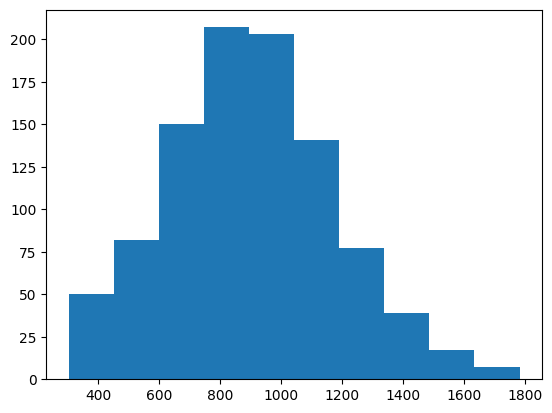

In [ ]:
df = pd.read_csv("/gym_dataset.csv")

X = df.drop(['Calories_Burned'], axis=1)
y = df['Calories_Burned']

print(X.info())
display(X.head(10))

plt.hist(y)
plt.show()

### TASK 1: Базовая модель (0.3 балла)
Построим базовую модель линейной регрессии

Как известно, фитнес-браслеты умеют выдавать значение потраченных калорий на основе пульса

Сделаем модель "фитнес-браслета": по классике, учтем показатель пульса во время тренировки, ее длительность, а также рост, вес и возраст клиента

Проинтерпретируйте полученную модель:

- Значима ли она в целом? 
- Значимы ли коэффициенты?
- Какую долю дисперсии она объясняет?
- Соответствует ли построенная модель здравому смыслу? Почему?

In [42]:
X1 = X[['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Session_Duration (hours)']]
X1 = sm.add_constant(X1)

### YOUR CODE HERE


In [ ]:
### YOUR CODE HERE

### TASK 2: Feature Engineering (1 балл)

Очевидно, что базовая модель неидеальна уже на уровне включаемых туда фич

- Преобразуйте показатели пульса (можно вдохновиться: https://www.polar.com/en/guide/heart-rate-zones)
- Подумайте, что еще из доступных фич с точки зрения здравого смысла и литературы имеет смысл включить и как
- Постройте новую модель, проведите необходимые тесты
- Сравните две модели, результаты какой Вам нравятся больше, почему?


- На данном этапе пока не думайте об условиях Г-М


In [ ]:
### YOUR CODE HERE

### TASK 3: Нормальность остатков (0.5 балла)

Почему нормальность остатков не является условием Г-М?

Почему ее все-таки проверяют?

Проверьте нормальность остатков минимум четыремя способами, проинтерпретируйте результаты

Как считаете, нужно ли "лечить" модель?

In [41]:
### YOUR CODE HERE

### TASK 4: Условия Г-М
Проверьте каждое из условий Гаусса-Маркова для Вашей модели из второго задания

Общая схема проверки включает в себя:

- Визуальный анализ, если возможно
- 2-3 статистических теста с интерпретацией
- Починку сломавшегося условия или попытку это сделать
- Если не починилось, то обязательно нужно сказать, какие последствия это имеет и в каких постановках на практике это будет важно



#### TASK 4.1 Мультиколлинеарность (1 балл)

Проверьте наличие частичной линейной зависимости в матрице наблюдений минимум двумя способами

Стоит ли корректировать ее наличие? Объясните свою позицию

Если считаете нужным, избавьтесь от этой проблемы любым подходящим способом

In [ ]:
### YOUR CODE HERE

##### Регуляризация (1 балл)

Один из известных способов побороть частичную мультиколлинеарность - добавить регуляризацию

- В чем преимущества и недостатки ипользования такого подхода?

- Докажите, что добавление регуляризации (L1, L2, ElasticNet) дает смещенные оценки




In [ ]:
### YOUR CODE HERE

#### TASK 4.2 Автокорреляция и гомоскедастичность (0.5 балла)

Проверьте наличие автокорреляции и гомоскедастичности несколькими известными Вам способами

Скорректируйте их наличие, если это возможно, любым известным Вам способом

In [ ]:
### YOUR CODE HERE

#### TASK 4.3 Эндогенность

##### Формальная проверка (0.5 баллов)

Формально проверьте наличие эндогенности любым известным Вам способом

Несмотря на результаты тестов и визуализации, как Вы считаете, есть ли эндогенность в построенной модели?

In [ ]:
### YOUR CODE HERE

##### Эндогенные переменные (1 балл)

Зачастую на первый взгляд не так-то просто сказать, какие именно переменные пропущены, и какие вследствие этого переменные в модели становятся эндогенными.

Именно поэтому эконометрические исследования славятся очень подробными обзорами литературы и погружением в научный контекст.

Попробуем немного погрузиться в спортивную медицину.

Изучите предложенные статьи:

- https://www.ideafit.com/wp-content/uploads/files/_archive/062005_calculatin.pdf
- https://pmc.ncbi.nlm.nih.gov/articles/PMC5663671/
- https://www.researchgate.net/publication/9025532_Effect_of_Exercise_Intensity_Duration_and_Mode_on_Post-Exercise_Oxygen_Consumption


На основе прочитанного, выдвините свое предположение, какие переменные пропущены и какие переменные в модели становятся эндогенными (их может быть больше одной)

In [ ]:
### YOUR THOUGHTS HERE

##### Инструменты (1 балл)

Сконструируйте инструменты на основе имеющихся данных, если это возможно

Оцените регрессию с инструментами двухшаговым МНК

In [ ]:
### YOUR CODE HERE

##### Польза инструментов (1 балл)

Что лучше, оценить регрессию, используя слабые инструменты?

Или не используя их вовсе?

Докажите свою мысль

In [ ]:
### YOUR THOUGHTS OR CODE HERE

#### TASK 4.4 Нулевое мат ожидание ошибки (0.5 балла)

После всех проделанных операций проверьте равенство мат. ожидания ошибок нулю

Насколько "страшны" последствия невыполнения такого условия?

In [ ]:
### YOUR CODE HERE

### TASK 5 Бинарная переменная (0.7 балла)

Есть идея о том, что мужчины и женщины расходуют разное кол-во калорий при выполнении упражнений одинаковой интенсивности

Как Вы считаете, есть ли смысл строить две отдельные модели для мужчин и женщин?

Проведите формальный тест Чоу на включение дамми-переменной 

- Вы можете описать суть теста Чоу и взять выкладки из статпакета, либо написать функцию для расчета

In [ ]:
### YOUR CODE HERE

### TASK 6 Интерпретация (1 балл)

- Проинтерпретируйте коэффициенты в финальной модели

- Оцените важность признаков в модели любыми известными способами

- Проговорите, какие у нее недостатки и для каких задач ее корректно использовать

- Если бы мы говорили о бизнес-постановке, как бы Вы сформировали тестовую выборку для модели?

- Каков был бы критерий качества для Вас?

In [ ]:
### YOUR CODE HERE